<h2 style='color:blue' align='center'>Sports Celebrity Image Classification<h2>

Special thanks to Debjyoti Paul (My data scientist friend at Amazon) for help with this project

In [2]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import os
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

In [3]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1200)])
  except RuntimeError as e:
    print('error --> ', e)


2023-11-16 16:08:00.222227: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-16 16:08:04.146959: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-16 16:08:04.147018: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-16 16:08:04.155772: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-16 16:08:05.350830: I tensorflow/core/platform/cpu_feature_g

done
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
done


2023-11-16 16:08:18.148382: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-16 16:08:20.311132: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-16 16:08:20.311449: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

<h3 style='color:purple'>(1) Preprocessing: Detect face and eyes</h3>

https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_objdetect/py_face_detection/py_face_detection.html?highlight=haar

In [4]:
img = cv2.imread('./politiciantest/obama.jpg')
img.shape

(408, 300, 3)

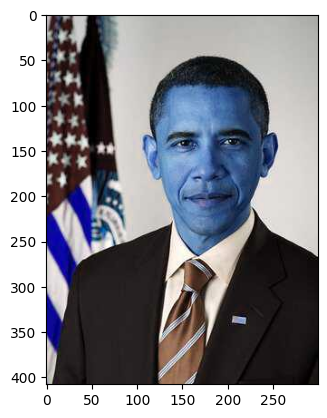

In [5]:
plt.imshow(img)

In [6]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape

(408, 300)

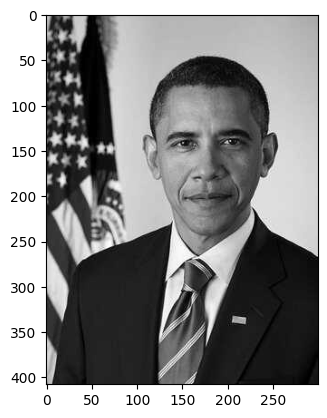

In [8]:
plt.imshow(gray, cmap='gray')

In [9]:
'***'
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')

In [15]:
faces = face_cascade.detectMultiScale(gray, 1.5, 3)
faces

array([[116,  96, 122, 122],
       [ 93,  70, 182, 182]], dtype=int32)

In [16]:
(x,y,w,h) = faces[0]
x,y,w,h

(116, 96, 122, 122)

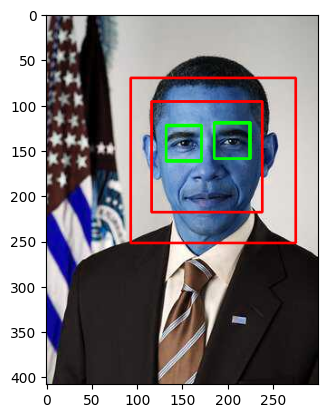

In [17]:
face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(face_img)

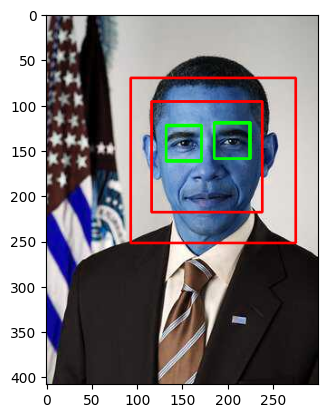

In [18]:
cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        

plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

#### (2) Preprocessing: Crop the facial region of the image

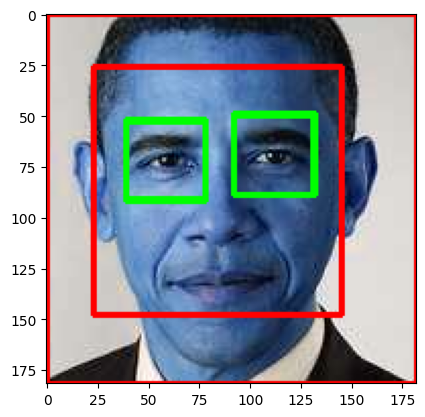

In [19]:
%matplotlib inline
plt.imshow(roi_color, cmap='gray')

In [20]:
cropped_img = np.array(roi_color)
cropped_img.shape

(182, 182, 3)

#### (3) Preprocessing: Use wavelet transform as a feature for traning the model

#### In wavelet transformed image, we can see edges clearly and that can give us clues on various facial features

#### Wavelet transform

In [21]:
'***'
import numpy as np
import pywt
import cv2    

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)
    
    # coeffs_H[0] *= 0;
    coeffs_H[0] *= 0;
    

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

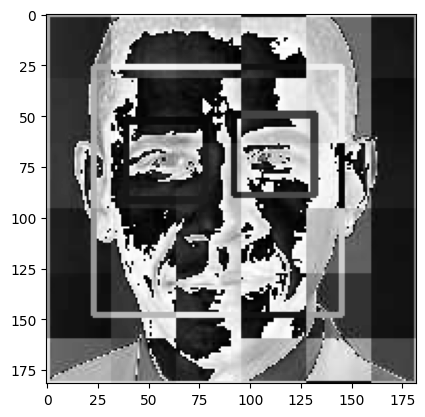

In [22]:
im_har = w2d(cropped_img,'db1',5)
plt.imshow(im_har, cmap='gray')

#### Preprocessing: Load image, detect face, then save and crop the face region

####  Lets write a python function that can take input image and returns cropped image (if face and eyes >=2 are detected)

In [26]:
'***'
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 0:
            return roi_color

In [27]:
'***'
path_to_data = "./dataset/"
path_to_cr_data = "./dataset/cropped/"

In [31]:
'***'
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [32]:
'***'
img_dirs

['./dataset/BillGates',
 './dataset/jin ping',
 './dataset/Kim jong un',
 './dataset/Fidel Castro',
 './dataset/Obama',
 './dataset/putin',
 './dataset/Trump',
 './dataset/Modi',
 './dataset/Nelson mandela',
 './dataset/joe biden']

**Go through all images in dataset folder and create cropped images for them. There will be cropped folder inside dataset folder after you run this code**

In [33]:
'*** not'
import shutil
if os.path.exists(path_to_cr_data):
     shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [34]:
'*** not'
cropped_image_dirs = []
celebrity_file_names_dict = {}
for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    celebrity_file_names_dict[celebrity_name] = []
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name
            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1

Generating cropped images in folder:  ./dataset/cropped/BillGates
Generating cropped images in folder:  ./dataset/cropped/jin ping
Generating cropped images in folder:  ./dataset/cropped/Kim jong un
Generating cropped images in folder:  ./dataset/cropped/Fidel Castro
Generating cropped images in folder:  ./dataset/cropped/Obama
Generating cropped images in folder:  ./dataset/cropped/putin
Generating cropped images in folder:  ./dataset/cropped/Trump
Generating cropped images in folder:  ./dataset/cropped/Modi
Generating cropped images in folder:  ./dataset/cropped/Nelson mandela
Generating cropped images in folder:  ./dataset/cropped/joe biden


### Now we can see cropped folder under datasets folder that contains cropped images

### Manually examine cropped folder and delete any unwanted images

In [35]:
print(cropped_image_dirs)

['./dataset/cropped/BillGates', './dataset/cropped/jin ping', './dataset/cropped/Kim jong un', './dataset/cropped/Fidel Castro', './dataset/cropped/Obama', './dataset/cropped/putin', './dataset/cropped/Trump', './dataset/cropped/Modi', './dataset/cropped/Nelson mandela', './dataset/cropped/joe biden']
